### Predicting the “Re-admission possibility of a patient into the hospital” 

In [218]:
#Import all required libraries
import pandas as pd
import numpy

from sklearn import preprocessing, metrics

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import learning_curve
%matplotlib inline
import numpy as np
import pandas as pd
#import graphviz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly
import plotly.offline as pyoff
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot, plot
import squarify # for tree maps
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier, export_graphviz,DecisionTreeRegressor
from sklearn.metrics import accuracy_score,classification_report, recall_score, precision_score,confusion_matrix,mean_absolute_error,mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.filterwarnings('ignore')

#### Import the Train data


In [219]:
Train=pd.read_csv("Train.csv",na_values=["?", ""])
Train_Diagnosis_TreatmentData=pd.read_csv("Train_Diagnosis_TreatmentData.csv",na_values=["?", ""])
Train_HospitalizationData=pd.read_csv("Train_HospitalizationData.csv",na_values=["?", ""])

#### Import the Test data


In [220]:
Test=pd.read_csv("Test.csv",na_values=["?", ""])
Test_Diagnosis_TreatmentData=pd.read_csv("Test_Diagnosis_TreatmentData.csv",na_values=["?", ""])
Test_HospitalizationData=pd.read_csv("Test_HospitalizationData.csv",na_values=["?", ""])

#### Check the shapes

In [221]:
Train.shape

(34650, 6)

In [222]:
Train_Diagnosis_TreatmentData.shape

(34650, 32)

In [223]:
Train_HospitalizationData.shape

(34650, 9)

#### See the top 5 rows of the data

In [224]:
Train.head()

,patientID,race,gender,age,weight,readmitted
0,PT11101,Caucasian,Male,[80-90),NaN,NO
1,PT11102,Caucasian,Male,[70-80),NaN,NO
2,PT11103,NaN,Female,[60-70),NaN,NO
3,PT11104,Caucasian,Female,[70-80),NaN,NO
4,PT11105,Caucasian,Female,[60-70),NaN,Within30days


In [225]:
Train_Diagnosis_TreatmentData.head()

,patientID,num_lab_procedures,num_procedures,num_medications,num_diagnoses,diagnosis_1,diagnosis_2,diagnosis_3,max_glu_serum,A1Cresult,...,miglitol,troglitazone,tolazamide,insulin,glyburide.metformin,glipizide.metformin,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed
0,PT11101,18,1,7,7,198,403,250,None,None,...,No,No,No,Up,No,No,No,No,Ch,Yes
1,PT11102,40,4,16,9,153,250,280,None,None,...,No,No,No,No,No,No,No,No,No,Yes
2,PT11103,39,1,12,5,535,250,401,None,None,...,No,No,No,No,Up,No,No,No,Ch,Yes
3,PT11104,1,0,10,9,786,411,787,None,None,...,No,No,No,No,No,No,No,No,No,Yes
4,PT11105,44,0,16,9,250.02,490,401,None,None,...,No,No,No,Steady,No,No,No,No,No,Yes


In [226]:
Train_HospitalizationData.head()

,AdmissionID,patientID,Admission_date,Discharge_date,admission_type_id,discharge_disposition_id,admission_source_id,payer_code,medical_specialty
0,ADM10251,PT36891,2014-01-01,2014-01-03,1,18,7,NaN,NaN
1,ADM10252,PT41433,2014-01-01,2014-01-07,1,3,7,MC,Emergency/Trauma
2,ADM10253,PT33024,2014-01-01,2014-01-02,1,11,7,CP,InternalMedicine
3,ADM10254,PT28054,2014-01-01,2014-01-05,2,1,1,NaN,InternalMedicine
4,ADM10255,PT20138,2014-01-01,2014-01-03,1,1,7,BC,NaN


In [227]:
Train.isnull().sum()

patientID         0
race           1079
gender            0
age               0
weight        33592
readmitted        0
dtype: int64

In [228]:
Train_Diagnosis_TreatmentData.isnull().sum()

patientID                    0
num_lab_procedures           0
num_procedures               0
num_medications              0
num_diagnoses                0
diagnosis_1                  6
diagnosis_2                179
diagnosis_3                681
max_glu_serum                0
A1Cresult                    0
metformin                    0
repaglinide                  0
nateglinide                  0
chlorpropamide               0
glimepiride                  0
acetohexamide                0
glipizide                    0
glyburide                    0
tolbutamide                  0
pioglitazone                 0
rosiglitazone                0
acarbose                     0
miglitol                     0
troglitazone                 0
tolazamide                   0
insulin                      0
glyburide.metformin          0
glipizide.metformin          0
metformin.rosiglitazone      0
metformin.pioglitazone       0
change                       0
diabetesMed                  0
dtype: i

In [229]:
Train_HospitalizationData.isnull().sum()

AdmissionID                     0
patientID                       0
Admission_date                  0
Discharge_date                  0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
payer_code                  14719
medical_specialty           16394
dtype: int64

#### Merge files

In [230]:
train_final = pd.merge(Train,Train_Diagnosis_TreatmentData, on='patientID')
train_final = pd.merge(train_final,Train_HospitalizationData, on='patientID')

In [231]:
test_final = pd.merge(Test,Test_Diagnosis_TreatmentData, on='patientID')
test_final = pd.merge(test_final,Test_HospitalizationData, on='patientID')

#### Check shape after merging 

In [232]:
train_final.shape

(34650, 45)

In [233]:
test_final.shape

(14630, 44)

#### Checking missing value percentage in each column

In [234]:
percent_missing = train_final.isnull().sum() * 100 / len(train_final)
missing_value = pd.DataFrame({'percent_missing': percent_missing})
missing_value.sort_values('percent_missing', ascending=False)

,percent_missing
weight,96.946609
medical_specialty,47.313131
payer_code,42.479076
race,3.113997
diagnosis_3,1.965368
diagnosis_2,0.516595
diagnosis_1,0.017316
discharge_disposition_id,0.000000
metformin.rosiglitazone,0.000000
miglitol,0.000000


In [370]:
init_notebook_mode(connected=True)

In [371]:
data = [go.Bar(
            x=['weight', 'medical_specialty	', 'payer_code', 'race', 'diagnosis_3', 'diagnosis_2', 'diagnosis_1'],
            y=[96.95, 47.31, 42.47, 3.11, 1.97, 0.52, 0.02],)]
       
             
iplot(data)

##### Actions Based on NA values percentage

In [237]:
traindup = train_final.drop(["weight", "payer_code", "medical_specialty"], axis = 1) 

In [238]:
testdup = test_final.drop(["weight", "payer_code", "medical_specialty"], axis = 1) 

In [239]:
traindup.shape

(34650, 42)

In [240]:
train_dis_11=traindup[traindup.discharge_disposition_id==11]
train_dis_19=traindup[traindup.discharge_disposition_id==19]
train_dis_20=traindup[traindup.discharge_disposition_id==20]
train_dis_21=traindup[traindup.discharge_disposition_id==21]

In [241]:
test_dis_11=testdup[testdup.discharge_disposition_id==11]
test_dis_19=testdup[testdup.discharge_disposition_id==19]
test_dis_20=testdup[testdup.discharge_disposition_id==20]
test_dis_21=testdup[testdup.discharge_disposition_id==21]

In [242]:

### As the discharge disposition of 11,13,14,19,20,21 are not making up any predictions so we will be removing them from 
### train data and as they are under the case of No condition we will be replacing them with NO directly.

### 768 data points are been droped from the train data
train_discharge=traindup[(traindup.discharge_disposition_id!=11) | (traindup.discharge_disposition_id!=19) | (traindup.discharge_disposition_id!=20) | (traindup.discharge_disposition_id!=21)]

In [243]:
test_discharge=testdup[(testdup.discharge_disposition_id!=11) | (testdup.discharge_disposition_id!=19) | (testdup.discharge_disposition_id!=20) | (testdup.discharge_disposition_id!=21)]

In [244]:
train_discharge.shape

(34650, 42)

In [245]:
carat_table = pd.crosstab(index=train_discharge["age"], 
                          columns=train_discharge["readmitted"])

carat_table

readmitted,NO,Within30days
age,,
[0-10),88,2
[10-20),260,17
[20-30),536,62
[30-40),1313,155
[40-50),3016,393
[50-60),5465,633
[60-70),6589,1088
[70-80),7140,1392
[80-90),4592,894


#### Plotted all the graphs, but kept required one

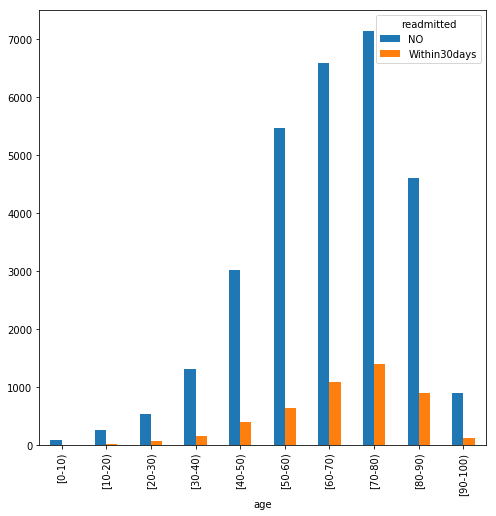

In [246]:
carat_table.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=False)

In [247]:
carat_table1 = pd.crosstab(index=train_discharge["gender"], 
                          columns=train_discharge["readmitted"])

carat_table1

readmitted,NO,Within30days
gender,,
Female,15679,2543
Male,14212,2216


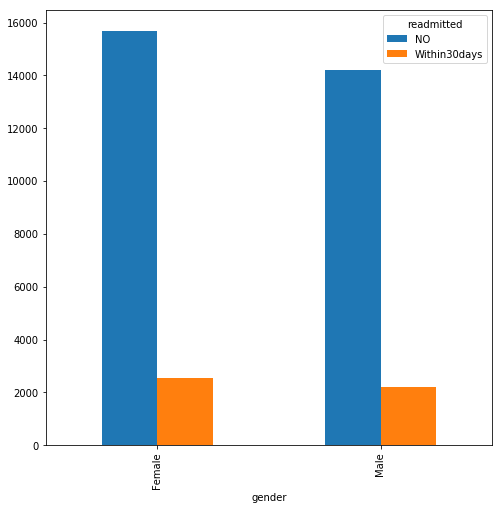

In [248]:
carat_table1.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=False)

In [249]:
carat_table9 = pd.crosstab(index=train_discharge["acetohexamide"], 
                          columns=train_discharge["readmitted"])

carat_table9

readmitted,NO,Within30days
acetohexamide,,
No,29891,4759


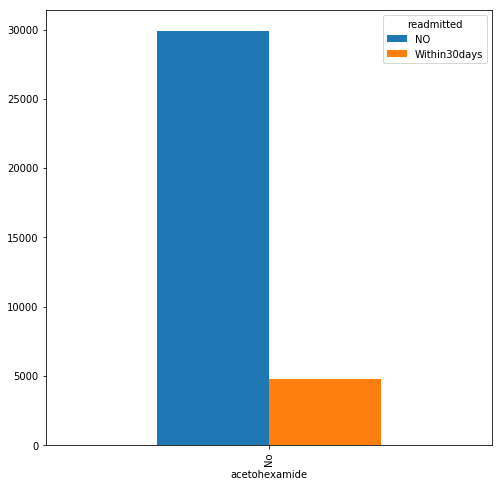

In [250]:
carat_table9.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=False)

In [251]:
carat_table17 = pd.crosstab(index=train_discharge["tolbutamide"], 
                          columns=train_discharge["readmitted"])

carat_table17

readmitted,NO,Within30days
tolbutamide,,
No,29883,4759
Steady,8,0


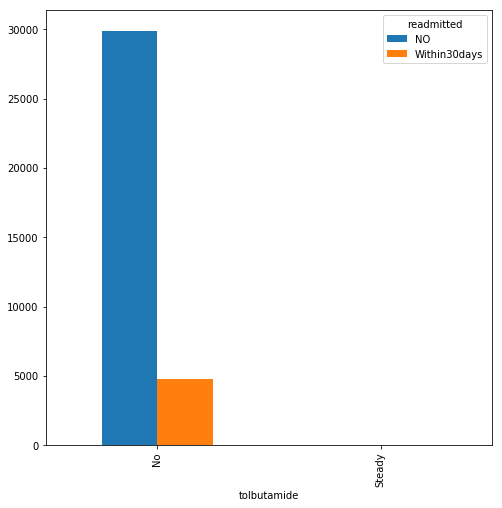

In [252]:
carat_table17.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=False)

In [253]:
carat_table19 = pd.crosstab(index=train_discharge["insulin"], 
                          columns=train_discharge["readmitted"])

carat_table19

readmitted,NO,Within30days
insulin,,
Down,2904,580
No,15036,2132
Steady,9233,1554
Up,2718,493


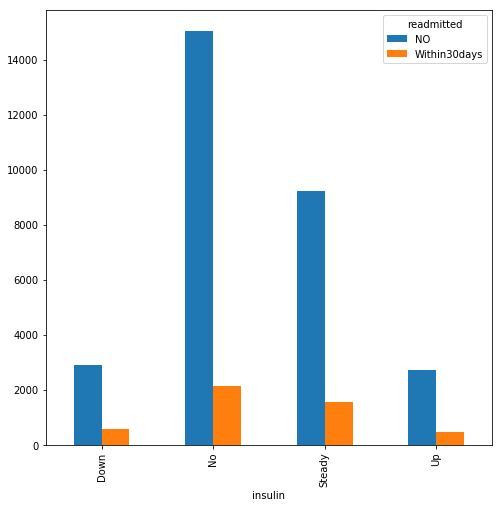

In [254]:
carat_table19.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=False)

In [255]:
carat_table20 = pd.crosstab(index=train_discharge["glyburide.metformin"], 
                          columns=train_discharge["readmitted"])

carat_table20

readmitted,NO,Within30days
glyburide.metformin,,
Down,1,0
No,29706,4728
Steady,179,31
Up,5,0


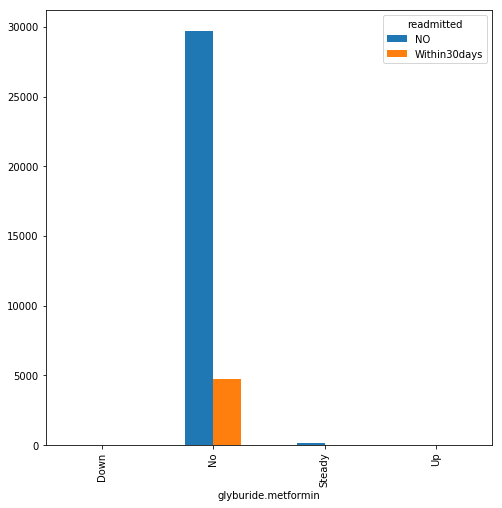

In [256]:
carat_table20.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=False)

In [257]:
carat_table24 = pd.crosstab(index=train_discharge["change"], 
                          columns=train_discharge["readmitted"])


carat_table24

readmitted,NO,Within30days
change,,
Ch,12863,2256
No,17028,2503


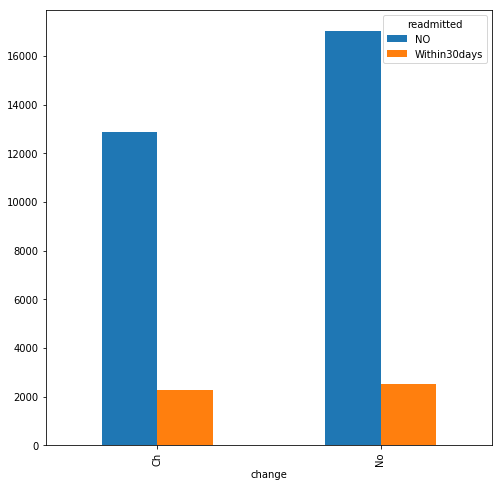

In [258]:
carat_table24.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=False)

In [259]:
carat_table25 = pd.crosstab(index=train_discharge["admission_type_id"], 
                          columns=train_discharge["readmitted"])

carat_table25

readmitted,NO,Within30days
admission_type_id,,
1,15105,2478
2,5463,871
3,6244,868
4,4,1
5,1312,201
6,1603,324
7,16,0
8,144,16


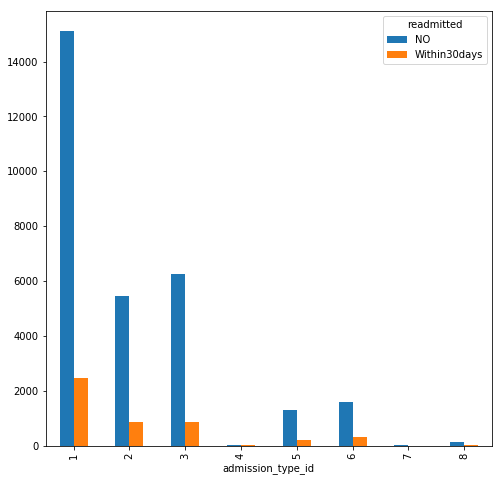

In [260]:
carat_table25.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=False)

In [261]:
carat_table26 = pd.crosstab(index=train_discharge["discharge_disposition_id"], 
                          columns=train_discharge["readmitted"])

carat_table26

readmitted,NO,Within30days
discharge_disposition_id,,
1,18956,2331
2,576,180
3,3391,871
4,226,45
5,332,128
6,3026,608
7,168,26
8,27,5
9,4,0


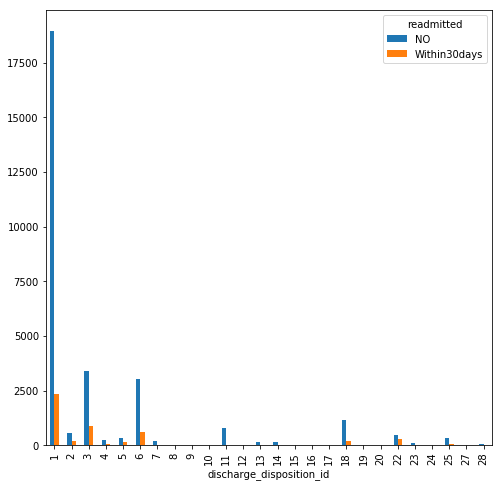

In [262]:
carat_table26.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=False)

In [263]:
carat_table27 = pd.crosstab(index=train_discharge["admission_source_id"], 
                          columns=train_discharge["readmitted"])

carat_table27

readmitted,NO,Within30days
admission_source_id,,
1,9516,1418
2,448,62
3,50,15
4,1293,174
5,243,42
6,950,117
7,15371,2566
8,5,1
9,61,8


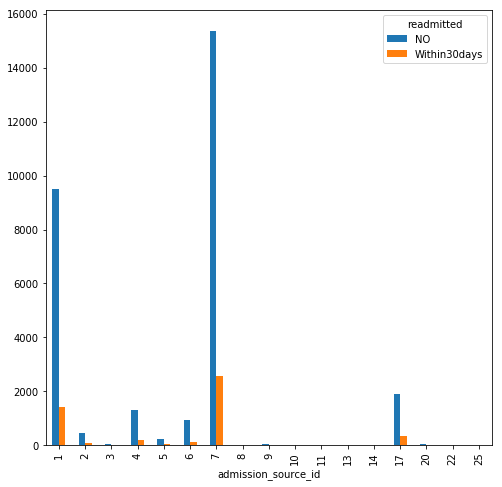

In [264]:
carat_table27.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=False)

#### Equalising the Levels              

In [265]:
# convert some numeric attributes to factors
cols=["admission_type_id","discharge_disposition_id","admission_source_id"]

In [266]:
#train_discharge[cols] = lapply(train_discharge[cols], factor)
for col in cols : 
    train_discharge[cols].astype("category")

In [267]:
for col in cols : 
    test_discharge[cols].astype("category")

In [268]:
print(list(train_discharge[cols]))

['admission_type_id', 'discharge_disposition_id', 'admission_source_id']


In [269]:
print(train_discharge.admission_type_id.unique())

[2 1 5 3 6 8 7 4]


In [270]:
# Convert the levels of admission type id into two levels
train_discharge_admission_type_id = {1:'emergency',
          2:'emergency',
          3:'casual',
          4:'casual',
          5:'casual',
          6:'casual',
          7:'emergency',
          8:'casual',
          }

In [271]:
# Convert the levels of admission type id into two levels
test_discharge_admission_type_id = {1:'emergency',
          2:'emergency',
          3:'casual',
          4:'casual',
          5:'casual',
          6:'casual',
          7:'emergency',
          8:'casual',
          }

In [272]:
train_discharge = train_discharge.replace({"admission_type_id":train_discharge_admission_type_id})

In [273]:
test_discharge = test_discharge.replace({"admission_type_id":train_discharge_admission_type_id})

In [274]:
train_discharge.head()

,patientID,race,gender,age,readmitted,num_lab_procedures,num_procedures,num_medications,num_diagnoses,diagnosis_1,...,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,AdmissionID,Admission_date,Discharge_date,admission_type_id,discharge_disposition_id,admission_source_id
0,PT11101,Caucasian,Male,[80-90),NO,18,1,7,7,198,...,No,No,Ch,Yes,ADM31792,2015-07-18,2015-07-23,emergency,1,7
1,PT11102,Caucasian,Male,[70-80),NO,40,4,16,9,153,...,No,No,No,Yes,ADM42286,2016-04-23,2016-04-29,emergency,3,7
2,PT11103,NaN,Female,[60-70),NO,39,1,12,5,535,...,No,No,Ch,Yes,ADM43029,2016-05-13,2016-05-17,emergency,1,1
3,PT11104,Caucasian,Female,[70-80),NO,1,0,10,9,786,...,No,No,No,Yes,ADM30585,2015-06-16,2015-06-18,emergency,1,7
4,PT11105,Caucasian,Female,[60-70),Within30days,44,0,16,9,250.02,...,No,No,No,Yes,ADM40516,2016-03-08,2016-03-09,emergency,1,7


In [275]:
# Convert the levels of discharge_disposition_id 
train_discharge_discharge_disposition_id = {1:'dis_home',
          2:'Another_hopital',
          3:'SNF',
          4:'ICF',
          5:'Another_ICU',
          6:'Home_HomeHealthSevrice',
          7:'AMA',
          8:'Nothing',
          9:'Nothing',
          10:'Nothing',
          11:'Nothing',
          12:'Nothing',
          13:'MF',
          14:'SNF',
          15:'Nothing',
          16:'Nothing',
          17:'Null',
          18:'Another_Rehab',
          19:'Long_term',
          20:'Nothing',
          21:'Not_Mapped',
          22:'Nothing',
          23:'Pshychiartic',
          24:'Expired'
          }
          

In [276]:
# Convert the levels of discharge_disposition_id 
test_discharge_discharge_disposition_id = {1:'dis_home',
          2:'Another_hopital',
          3:'SNF',
          4:'ICF',
          5:'Another_ICU',
          6:'Home_HomeHealthSevrice',
          7:'AMA',
          8:'Nothing',
          9:'Nothing',
          10:'Nothing',
          11:'Nothing',
          12:'Nothing',
          13:'MF',
          14:'SNF',
          15:'Nothing',
          16:'Nothing',
          17:'Null',
          18:'Another_Rehab',
          19:'Long_term',
          20:'Nothing',
          21:'Not_Mapped',
          22:'Nothing',
          23:'Pshychiartic',
          24:'Expired'
          }
          

In [277]:
train_discharge = train_discharge.replace({"discharge_disposition_id":train_discharge_discharge_disposition_id})

In [278]:
test_discharge = test_discharge.replace({"discharge_disposition_id":test_discharge_discharge_disposition_id})

In [279]:
train_discharge.head(2)

,patientID,race,gender,age,readmitted,num_lab_procedures,num_procedures,num_medications,num_diagnoses,diagnosis_1,...,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,AdmissionID,Admission_date,Discharge_date,admission_type_id,discharge_disposition_id,admission_source_id
0,PT11101,Caucasian,Male,[80-90),NO,18,1,7,7,198,...,No,No,Ch,Yes,ADM31792,2015-07-18,2015-07-23,emergency,dis_home,7
1,PT11102,Caucasian,Male,[70-80),NO,40,4,16,9,153,...,No,No,No,Yes,ADM42286,2016-04-23,2016-04-29,emergency,SNF,7


In [280]:
# Convert the levels of admission_source_id
train_discharge_admission_source_id = {1:'1',2:'2',3:'3',4:'4',5:'5',6:'4',7:'7',8:'8',9:'9',10:'4',11:'11',12:'13',13:'14',14:'9',15:'9',16:'22',17:'25'}

In [281]:
# Convert the levels of admission_source_id
test_discharge_admission_source_id = {1:'1',2:'2',3:'3',4:'4',5:'5',6:'4',7:'7',8:'8',9:'9',10:'4',11:'11',12:'13',13:'14',14:'9',15:'9',16:'22',17:'25'}

In [282]:
train_discharge = train_discharge.replace({"admission_source_id":train_discharge_admission_source_id})

In [283]:
test_discharge = test_discharge.replace({"admission_source_id":test_discharge_admission_source_id})

In [284]:
test_discharge.head()

,patientID,race,gender,age,num_lab_procedures,num_procedures,num_medications,num_diagnoses,diagnosis_1,diagnosis_2,...,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,AdmissionID,Admission_date,Discharge_date,admission_type_id,discharge_disposition_id,admission_source_id
0,PT60251,Caucasian,Female,[60-70),49,0,9,9,8,276,...,No,No,No,No,ADM71912,2016-08-19,2016-08-23,emergency,SNF,7
1,PT60252,Caucasian,Male,[50-60),42,3,28,7,414,997,...,No,No,Ch,Yes,ADM71036,2016-07-19,2016-07-23,casual,Home_HomeHealthSevrice,1
2,PT60253,Caucasian,Female,[50-60),61,1,15,6,162,197,...,No,No,Ch,Yes,ADM77733,2017-02-28,2017-03-11,casual,dis_home,7
3,PT60254,AfricanAmerican,Female,[40-50),35,4,29,8,626,340,...,No,No,No,Yes,ADM70695,2016-07-08,2016-07-12,casual,Another_Rehab,1
4,PT60255,Caucasian,Female,[60-70),56,1,22,9,250.8,263,...,No,No,No,No,ADM83536,2017-09-08,2017-09-16,emergency,SNF,5


In [285]:
# Convert age two numeric from ordinal
train_discharge_age = {'[10-20)':'5','[10-20)':'15','[20-30)':'25','[30-40)':'35','[40-50)':'45','[50-60)':'55','[60-70)':'65','[70-80)':'75','[80-90)':'85','[90-100)':'95'}

In [286]:
# Convert age two numeric from ordinal
test_discharge_age = {'[10-20)':'5','[10-20)':'15','[20-30)':'25','[30-40)':'35','[40-50)':'45','[50-60)':'55','[60-70)':'65','[70-80)':'75','[80-90)':'85','[90-100)':'95'}

In [287]:
train_discharge = train_discharge.replace({"age":train_discharge_age})

In [288]:
test_discharge = test_discharge.replace({"age":test_discharge_age})

In [289]:
train_discharge.head()

,patientID,race,gender,age,readmitted,num_lab_procedures,num_procedures,num_medications,num_diagnoses,diagnosis_1,...,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,AdmissionID,Admission_date,Discharge_date,admission_type_id,discharge_disposition_id,admission_source_id
0,PT11101,Caucasian,Male,85,NO,18,1,7,7,198,...,No,No,Ch,Yes,ADM31792,2015-07-18,2015-07-23,emergency,dis_home,7
1,PT11102,Caucasian,Male,75,NO,40,4,16,9,153,...,No,No,No,Yes,ADM42286,2016-04-23,2016-04-29,emergency,SNF,7
2,PT11103,NaN,Female,65,NO,39,1,12,5,535,...,No,No,Ch,Yes,ADM43029,2016-05-13,2016-05-17,emergency,dis_home,1
3,PT11104,Caucasian,Female,75,NO,1,0,10,9,786,...,No,No,No,Yes,ADM30585,2015-06-16,2015-06-18,emergency,dis_home,7
4,PT11105,Caucasian,Female,65,Within30days,44,0,16,9,250.02,...,No,No,No,Yes,ADM40516,2016-03-08,2016-03-09,emergency,dis_home,7


In [290]:
# Create the features named No of days and the month in which they stayed in hospital before discharge
cols=["Admission_date","Discharge_date"]

train_discharge.Discharge_date= train_discharge.Discharge_date.astype('datetime64')
train_discharge.Admission_date= train_discharge.Admission_date.astype('datetime64')
train_discharge['No_of_days_Stayed']=(train_discharge.Discharge_date-train_discharge.Admission_date).dt.days
train_discharge['Month_of_year']=(train_discharge.Admission_date).dt.month




In [291]:
cols=["Admission_date","Discharge_date"]

test_discharge.Discharge_date= test_discharge.Discharge_date.astype('datetime64')
test_discharge.Admission_date= test_discharge.Admission_date.astype('datetime64')
test_discharge['No_of_days_Stayed']=(test_discharge.Discharge_date-test_discharge.Admission_date).dt.days
test_discharge['Month_of_year']=(test_discharge.Admission_date).dt.month




In [292]:
train_discharge.head()

,patientID,race,gender,age,readmitted,num_lab_procedures,num_procedures,num_medications,num_diagnoses,diagnosis_1,...,change,diabetesMed,AdmissionID,Admission_date,Discharge_date,admission_type_id,discharge_disposition_id,admission_source_id,No_of_days_Stayed,Month_of_year
0,PT11101,Caucasian,Male,85,NO,18,1,7,7,198,...,Ch,Yes,ADM31792,2015-07-18,2015-07-23,emergency,dis_home,7,5,7
1,PT11102,Caucasian,Male,75,NO,40,4,16,9,153,...,No,Yes,ADM42286,2016-04-23,2016-04-29,emergency,SNF,7,6,4
2,PT11103,NaN,Female,65,NO,39,1,12,5,535,...,Ch,Yes,ADM43029,2016-05-13,2016-05-17,emergency,dis_home,1,4,5
3,PT11104,Caucasian,Female,75,NO,1,0,10,9,786,...,No,Yes,ADM30585,2015-06-16,2015-06-18,emergency,dis_home,7,2,6
4,PT11105,Caucasian,Female,65,Within30days,44,0,16,9,250.02,...,No,Yes,ADM40516,2016-03-08,2016-03-09,emergency,dis_home,7,1,3


In [293]:
#Just renaming the levels for better understanding

train_discharge_A1Cresult = {'>7':"abnormal",'>8':"abnormal",'None':"not_tested",'Norm':"normal"}

In [294]:
#Just renaming the levels for better understanding

test_discharge_A1Cresult = {'>7':"abnormal",'>8':"abnormal",'None':"not_tested",'Norm':"normal"}

In [295]:
train_discharge = train_discharge.replace({"A1Cresult":train_discharge_A1Cresult})

In [296]:
test_discharge = test_discharge.replace({"A1Cresult":test_discharge_A1Cresult})

In [297]:
train_discharge.A1Cresult.head()

0    not_tested
1    not_tested
2    not_tested
3    not_tested
4    not_tested
Name: A1Cresult, dtype: object

In [298]:
#Just renaming the levels for better understanding
train_discharge_max_glu_serum = {'>200':"abnormal",'>300':"abnormal",'None':"not_tested",'Norm':"normal"}

In [299]:
#Just renaming the levels for better understanding
test_discharge_max_glu_serum = {'>200':"abnormal",'>300':"abnormal",'None':"not_tested",'Norm':"normal"}

In [300]:
train_discharge = train_discharge.replace({"max_glu_serum":train_discharge_max_glu_serum})

In [301]:
test_discharge = test_discharge.replace({"max_glu_serum":test_discharge_max_glu_serum})

In [302]:
train_discharge.max_glu_serum.head()

0    not_tested
1    not_tested
2    not_tested
3    not_tested
4    not_tested
Name: max_glu_serum, dtype: object

#### Remove the variables which are not useful

In [303]:
train_discharge.describe

<bound method NDFrame.describe of       patientID             race  gender age    readmitted  \
0       PT11101        Caucasian    Male  85            NO   
1       PT11102        Caucasian    Male  75            NO   
2       PT11103              NaN  Female  65            NO   
3       PT11104        Caucasian  Female  75            NO   
4       PT11105        Caucasian  Female  65  Within30days   
5       PT11106  AfricanAmerican    Male  45            NO   
6       PT11107  AfricanAmerican  Female  45            NO   
7       PT11108        Caucasian  Female  75            NO   
8       PT11109        Caucasian  Female  75            NO   
9       PT11110        Caucasian  Female  95            NO   
10      PT11111  AfricanAmerican    Male  55  Within30days   
11      PT11112        Caucasian  Female  85            NO   
12      PT11113        Caucasian  Female  55            NO   
13      PT11114        Caucasian  Female  55            NO   
14      PT11115        Caucasian    

In [304]:
train_drop = train_discharge.drop(['patientID','acetohexamide','AdmissionID','Admission_date','Discharge_date'], axis=1)

In [305]:
test_drop = test_discharge.drop(['acetohexamide','AdmissionID','Admission_date','Discharge_date'], axis=1)

In [306]:
train_drop.head()

,race,gender,age,readmitted,num_lab_procedures,num_procedures,num_medications,num_diagnoses,diagnosis_1,diagnosis_2,...,glipizide.metformin,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,admission_type_id,discharge_disposition_id,admission_source_id,No_of_days_Stayed,Month_of_year
0,Caucasian,Male,85,NO,18,1,7,7,198,403,...,No,No,No,Ch,Yes,emergency,dis_home,7,5,7
1,Caucasian,Male,75,NO,40,4,16,9,153,250,...,No,No,No,No,Yes,emergency,SNF,7,6,4
2,NaN,Female,65,NO,39,1,12,5,535,250,...,No,No,No,Ch,Yes,emergency,dis_home,1,4,5
3,Caucasian,Female,75,NO,1,0,10,9,786,411,...,No,No,No,No,Yes,emergency,dis_home,7,2,6
4,Caucasian,Female,65,Within30days,44,0,16,9,250.02,490,...,No,No,No,No,Yes,emergency,dis_home,7,1,3


In [307]:
train_drop.columns

Index(['race', 'gender', 'age', 'readmitted', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'num_diagnoses', 'diagnosis_1',
       'diagnosis_2', 'diagnosis_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'insulin', 'glyburide.metformin', 'glipizide.metformin',
       'metformin.rosiglitazone', 'metformin.pioglitazone', 'change',
       'diabetesMed', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'No_of_days_Stayed', 'Month_of_year'],
      dtype='object')

In [308]:
target_temp=train_drop.readmitted

In [309]:
target=train_drop.readmitted

In [310]:
train_drop.head()

,race,gender,age,readmitted,num_lab_procedures,num_procedures,num_medications,num_diagnoses,diagnosis_1,diagnosis_2,...,glipizide.metformin,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,admission_type_id,discharge_disposition_id,admission_source_id,No_of_days_Stayed,Month_of_year
0,Caucasian,Male,85,NO,18,1,7,7,198,403,...,No,No,No,Ch,Yes,emergency,dis_home,7,5,7
1,Caucasian,Male,75,NO,40,4,16,9,153,250,...,No,No,No,No,Yes,emergency,SNF,7,6,4
2,NaN,Female,65,NO,39,1,12,5,535,250,...,No,No,No,Ch,Yes,emergency,dis_home,1,4,5
3,Caucasian,Female,75,NO,1,0,10,9,786,411,...,No,No,No,No,Yes,emergency,dis_home,7,2,6
4,Caucasian,Female,65,Within30days,44,0,16,9,250.02,490,...,No,No,No,No,Yes,emergency,dis_home,7,1,3


In [311]:
target = {'NO':0,'Within30days':1}

In [312]:
train_drop = train_drop.replace({"readmitted":target})

In [313]:
target=train_drop.readmitted

In [314]:
target.head()

0    0
1    0
2    0
3    0
4    1
Name: readmitted, dtype: int64

In [315]:
train_drop.head()

,race,gender,age,readmitted,num_lab_procedures,num_procedures,num_medications,num_diagnoses,diagnosis_1,diagnosis_2,...,glipizide.metformin,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,admission_type_id,discharge_disposition_id,admission_source_id,No_of_days_Stayed,Month_of_year
0,Caucasian,Male,85,0,18,1,7,7,198,403,...,No,No,No,Ch,Yes,emergency,dis_home,7,5,7
1,Caucasian,Male,75,0,40,4,16,9,153,250,...,No,No,No,No,Yes,emergency,SNF,7,6,4
2,NaN,Female,65,0,39,1,12,5,535,250,...,No,No,No,Ch,Yes,emergency,dis_home,1,4,5
3,Caucasian,Female,75,0,1,0,10,9,786,411,...,No,No,No,No,Yes,emergency,dis_home,7,2,6
4,Caucasian,Female,65,1,44,0,16,9,250.02,490,...,No,No,No,No,Yes,emergency,dis_home,7,1,3


In [316]:
traintoput=train_drop.drop('readmitted',axis=1)

#### Imputation

In [317]:
traintoput.race = traintoput.race.fillna(traintoput['race'].value_counts().index[0])
traintoput.diagnosis_1 = traintoput.diagnosis_1.fillna(traintoput['diagnosis_1'].value_counts().index[0])
traintoput.diagnosis_2 = traintoput.diagnosis_2.fillna(traintoput['diagnosis_2'].value_counts().index[0])
traintoput.diagnosis_3 = traintoput.diagnosis_3.fillna(traintoput['diagnosis_3'].value_counts().index[0])

In [318]:
traintoput.shape

(34650, 38)

In [319]:
test_drop.race = test_drop.race.fillna(test_drop['race'].value_counts().index[0])
test_drop.diagnosis_1 = test_drop.diagnosis_1.fillna(test_drop['diagnosis_1'].value_counts().index[0])
test_drop.diagnosis_2 = test_drop.diagnosis_2.fillna(test_drop['diagnosis_2'].value_counts().index[0])
test_drop.diagnosis_3 = test_drop.diagnosis_3.fillna(test_drop['diagnosis_3'].value_counts().index[0])

In [320]:
test_drop.columns

Index(['patientID', 'race', 'gender', 'age', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'num_diagnoses', 'diagnosis_1',
       'diagnosis_2', 'diagnosis_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'insulin', 'glyburide.metformin', 'glipizide.metformin',
       'metformin.rosiglitazone', 'metformin.pioglitazone', 'change',
       'diabetesMed', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'No_of_days_Stayed', 'Month_of_year'],
      dtype='object')

In [321]:
test_drop.isna().sum()

patientID                   0
race                        0
gender                      0
age                         0
num_lab_procedures          0
num_procedures              0
num_medications             0
num_diagnoses               0
diagnosis_1                 0
diagnosis_2                 0
diagnosis_3                 0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
insulin                     0
glyburide.metformin         0
glipizide.metformin         0
metformin.rosiglitazone     0
metformin.pioglitazone      0
change                      0
diabetesMe

#### ICD Code for 3 diagnosis columns

In [322]:
def diagnosis_ICD_codes (icd) :
    result = "Other"
    try:
        code =float(icd)
    except:
        return result

    if code >= 0.0 and code <= 139.0 :
        result = "Parasitic";
  
    elif(code > 139.0 and code <= 239.0) :
        result = "Neoplasms";
  
    elif (code > 239.0 and code <= 279.0) :
        result = "E_N_M";
  
    elif (code > 279.0 and code <= 289.0) :
        result = "BloodDiseases";
  
    elif (code > 289.0 and code <= 319.0) :
        result = "MentalDisorders";
  
    elif (code > 319.0 and code <= 389.0) :
        result = "NervousSystems";
  
    elif (code > 389.00 and code <= 459.0) :
        result = "Circulatory";
  
    elif (code > 459.0 and code <= 519.0) :
        result = "Respiratory";
  
    elif (code > 520 and code <= 579.0) :
        result = "Digestive";
  
    elif (code > 579.0 and code <= 629.0) :
        result = "Gentitorinary";
  
    elif (code > 629.0 and code <= 679.0) :
        result = "Ginic";
  
    elif (code > 679.0 and code <= 709.0) :
        result = "Skin";
  
    elif (code > 709.0 and code <= 739.0) :
        result = "Masculoskeletal";
  
    elif (code > 739.0 and code <= 759.0) :
        result = "CongenitalAnamolies";
  
    elif (code > 759.0 and code <= 779.0) :
        result = "ParinetalPeriod";
  
    elif (code > 779.0 and code <= 799.0) :
        result = "NoSymptoms";
  
    elif (code > 799.0 and code <= 999.0) :
        result = "Injury";
  
    else :
        result = "Other";
  
    return result


In [323]:
traintoput['diagnosis_1_stamp'] = traintoput.apply (lambda row: diagnosis_ICD_codes(row['diagnosis_1']), axis=1)
traintoput['diagnosis_2_stamp'] = traintoput.apply (lambda row: diagnosis_ICD_codes(row['diagnosis_2']), axis=1)
traintoput['diagnosis_3_stamp'] = traintoput.apply (lambda row: diagnosis_ICD_codes(row['diagnosis_3']), axis=1)

In [324]:
test_drop['diagnosis_1_stamp'] = test_drop.apply (lambda row: diagnosis_ICD_codes(row['diagnosis_1']), axis=1)
test_drop['diagnosis_2_stamp'] = test_drop.apply (lambda row: diagnosis_ICD_codes(row['diagnosis_2']), axis=1)
test_drop['diagnosis_3_stamp'] = test_drop.apply (lambda row: diagnosis_ICD_codes(row['diagnosis_3']), axis=1)

In [325]:
traintoput.shape

(34650, 41)

In [326]:
traintoput=traintoput.drop(['diagnosis_1','diagnosis_2','diagnosis_3'],axis=1)

In [327]:
test_drop=test_drop.drop(['diagnosis_1','diagnosis_2','diagnosis_3'],axis=1)

In [328]:
test_drop.shape

(14630, 39)

In [329]:
#traintoput = traintoput.to_csv (r'C:/Users/sa/Desktop/sa/Adarsh Data/2019/Common files/Big Data/BD/PHD/PHD Part 2/TrainData-1564147787554/20190728_6pm_TrainData/traintoput.csv', index = None, header=True)

#### Dummify 

In [330]:
traintoput=pd.get_dummies(traintoput)

In [331]:
traintoput.head()

,num_lab_procedures,num_procedures,num_medications,num_diagnoses,No_of_days_Stayed,Month_of_year,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,...,diagnosis_3_stamp_Injury,diagnosis_3_stamp_Masculoskeletal,diagnosis_3_stamp_MentalDisorders,diagnosis_3_stamp_Neoplasms,diagnosis_3_stamp_NervousSystems,diagnosis_3_stamp_NoSymptoms,diagnosis_3_stamp_Other,diagnosis_3_stamp_Parasitic,diagnosis_3_stamp_Respiratory,diagnosis_3_stamp_Skin
0,18,1,7,7,5,7,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,40,4,16,9,6,4,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,39,1,12,5,4,5,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,10,9,2,6,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,44,0,16,9,1,3,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [332]:
X_id=test_drop['patientID']

In [333]:
test_drop=test_drop.drop('patientID',axis=1)

In [334]:
testtoput=pd.get_dummies(test_drop)

In [335]:
traintoput=traintoput.drop(['chlorpropamide_Down','chlorpropamide_Up','troglitazone_Steady','metformin.pioglitazone_Steady','discharge_disposition_id_27','admission_source_id_11','admission_source_id_14'],axis=1)

In [336]:
testtoput.shape

(14630, 171)

In [337]:
traintoput.head()

,num_lab_procedures,num_procedures,num_medications,num_diagnoses,No_of_days_Stayed,Month_of_year,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,...,diagnosis_3_stamp_Injury,diagnosis_3_stamp_Masculoskeletal,diagnosis_3_stamp_MentalDisorders,diagnosis_3_stamp_Neoplasms,diagnosis_3_stamp_NervousSystems,diagnosis_3_stamp_NoSymptoms,diagnosis_3_stamp_Other,diagnosis_3_stamp_Parasitic,diagnosis_3_stamp_Respiratory,diagnosis_3_stamp_Skin
0,18,1,7,7,5,7,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,40,4,16,9,6,4,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,39,1,12,5,4,5,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,10,9,2,6,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,44,0,16,9,1,3,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [338]:
testtoput.columns

Index(['num_lab_procedures', 'num_procedures', 'num_medications',
       'num_diagnoses', 'No_of_days_Stayed', 'Month_of_year',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       ...
       'diagnosis_3_stamp_Injury', 'diagnosis_3_stamp_Masculoskeletal',
       'diagnosis_3_stamp_MentalDisorders', 'diagnosis_3_stamp_Neoplasms',
       'diagnosis_3_stamp_NervousSystems', 'diagnosis_3_stamp_NoSymptoms',
       'diagnosis_3_stamp_Other', 'diagnosis_3_stamp_Parasitic',
       'diagnosis_3_stamp_Respiratory', 'diagnosis_3_stamp_Skin'],
      dtype='object', length=171)

In [339]:
traintoput.head()

,num_lab_procedures,num_procedures,num_medications,num_diagnoses,No_of_days_Stayed,Month_of_year,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,...,diagnosis_3_stamp_Injury,diagnosis_3_stamp_Masculoskeletal,diagnosis_3_stamp_MentalDisorders,diagnosis_3_stamp_Neoplasms,diagnosis_3_stamp_NervousSystems,diagnosis_3_stamp_NoSymptoms,diagnosis_3_stamp_Other,diagnosis_3_stamp_Parasitic,diagnosis_3_stamp_Respiratory,diagnosis_3_stamp_Skin
0,18,1,7,7,5,7,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,40,4,16,9,6,4,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,39,1,12,5,4,5,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,10,9,2,6,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,44,0,16,9,1,3,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [340]:
test_drop.isna().sum()

race                        0
gender                      0
age                         0
num_lab_procedures          0
num_procedures              0
num_medications             0
num_diagnoses               0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
insulin                     0
glyburide.metformin         0
glipizide.metformin         0
metformin.rosiglitazone     0
metformin.pioglitazone      0
change                      0
diabetesMed                 0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
No_of_days

#### Insights I found in data after feature engineering

- Missing Values:The train data have 3 attributes with the more than 10% of their records missing such as weight (97%), payer     code (42%), and medical specialty (43%). 


- Clubbed the Drugs as required


- Added  new attributes No of Days Stayed and Month: This variable was being extracted based on the admission date and discharge   date. Stayed= discharge – admission. Month from the Admission Date.


- ICD code Levelling has been made.


- Releveling Attributes following 5 attributes:

  admission_type_id: It had 8 levels I made it down to 2 levels such as casual and emergency.
  
  discharge_disposition_id: It had 29 levels and out of which 4 levels were discarded and others were clubbed into 14             levels.
  
  admission_source_id: It had 26 levels which were clubbed into 12 levels.
  
  Age: It was in ordinal form in the given train data I converted them into numeric by just taking mean into account.
  A1Cresult and Ma Gluc serum: Renaming the levels for better intiution


#### Split data into train and test

In [341]:
y=target
X=traintoput
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state =546)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24255, 171)
(10395, 171)
(24255,)
(10395,)


In [342]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: readmitted, dtype: int64

In [343]:
Before_X_resampled = X_train
Before_y_resampled = y_train

In [344]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

In [345]:
X_train=pd.DataFrame(X_resampled)
y_train=y_resampled

In [150]:
X_train.shape

(41852, 171)

#### LogisticRegression

In [209]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### Check accuracy and recall on test data

In [210]:
y1_pred_ = log_reg.predict(X_train)
y_pred_ = log_reg.predict(X_test)

In [211]:
print("Recall : %5f" %recall_score(y_train,y1_pred_))
print("Accuracy : %5f" %accuracy_score(y_train,y1_pred_))
print(classification_report(y_train,y1_pred_,digits=4))
print("\n")

print("Recall : %5f" %recall_score(y_test,y_pred_))
print("Accuracy : %5f" %accuracy_score(y_test,y_pred_))
print(classification_report(y_test,y_pred_,digits=4))

Recall : 0.590557
Accuracy : 0.602600
              precision    recall  f1-score   support

           0     0.6002    0.6146    0.6073     20926
           1     0.6051    0.5906    0.5978     20926

    accuracy                         0.6026     41852
   macro avg     0.6027    0.6026    0.6025     41852
weighted avg     0.6027    0.6026    0.6025     41852



Recall : 0.575524
Accuracy : 0.610005
              precision    recall  f1-score   support

           0     0.9009    0.6155    0.7313      8965
           1     0.1927    0.5755    0.2888      1430

    accuracy                         0.6100     10395
   macro avg     0.5468    0.5955    0.5101     10395
weighted avg     0.8035    0.6100    0.6705     10395



In [216]:
print("Confusion Matrix : ")
print(confusion_matrix(y_test,y_pred_))

Confusion Matrix : 
[[5518 3447]
 [ 607  823]]


In [217]:
auc = roc_auc_score(y_test,y_pred_)
print('AUC: %.3f' % auc)

AUC: 0.596


#### SVM

In [360]:
from sklearn.svm import SVC

In [361]:
svc_model = SVC()

#### train our SVM model with our "training" dataset.


In [362]:
svc_model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [363]:
y_predict = svc_model.predict(X_test)

In [364]:
y1_pred_ = svc_model.predict(X_train)

In [365]:
print("Recall : %5f" %recall_score(y_train,y1_pred_))
print("Accuracy : %5f" %accuracy_score(y_train,y1_pred_))
print(classification_report(y_train,y1_pred_,digits=4))
print("\n")

print("Recall : %5f" %recall_score(y_test,y_predict))
print("Accuracy : %5f" %accuracy_score(y_test,y_predict))
print(classification_report(y_test,y_predict,digits=4))

Recall : 0.761445
Accuracy : 0.707851
              precision    recall  f1-score   support

           0     0.7328    0.6543    0.6913     20926
           1     0.6877    0.7614    0.7227     20926

    accuracy                         0.7079     41852
   macro avg     0.7103    0.7079    0.7070     41852
weighted avg     0.7103    0.7079    0.7070     41852



Recall : 0.544056
Accuracy : 0.610390
              precision    recall  f1-score   support

           0     0.8952    0.6210    0.7333      8965
           1     0.1863    0.5441    0.2776      1430

    accuracy                         0.6104     10395
   macro avg     0.5407    0.5825    0.5054     10395
weighted avg     0.7976    0.6104    0.6706     10395



In [367]:
print("Confusion Matrix : ")
print(confusion_matrix(y_test, y_predict))

Confusion Matrix : 
[[5567 3398]
 [ 652  778]]


In [368]:
auc = roc_auc_score(y_test,y_pred_)
print('AUC: %.3f' % auc)

AUC: 0.575


#### improving with normailzed data

In [98]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

In [99]:
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [100]:
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [101]:
svc_model = SVC()
svc_model.fit(X_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [102]:
y_predict = svc_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_predict)

In [103]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_predict))

0.6393458393458393


#### gridsearch model

In [420]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']} 

In [421]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=4)
grid.fit(X_train_scaled,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV]  C=0.001, gamma=0.001, kernel=rbf, score=0.8627256987385604, total= 6.3min
[CV] C=0.001, gamma=0.001, kernel=rbf ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.6min remaining:    0.0s


[CV]  C=0.001, gamma=0.001, kernel=rbf, score=0.862708719851577, total= 7.4min
[CV] C=0.001, gamma=0.001, kernel=rbf ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 24.0min remaining:    0.0s


[CV]  C=0.001, gamma=0.001, kernel=rbf, score=0.8628154379020287, total= 9.1min
[CV] C=0.001, gamma=0.01, kernel=rbf .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 39.2min remaining:    0.0s


[CV]  C=0.001, gamma=0.01, kernel=rbf, score=0.8627256987385604, total= 9.3min
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV]  C=0.001, gamma=0.01, kernel=rbf, score=0.862708719851577, total= 8.5min
[CV] C=0.001, gamma=0.01, kernel=rbf .................................
[CV]  C=0.001, gamma=0.01, kernel=rbf, score=0.8628154379020287, total= 9.1min
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................
[CV]  C=0.001, gamma=0.1, kernel=rbf, score=0.8627256987385604, total= 9.0min
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................
[CV]  C=0.001, gamma=0.1, kernel=rbf, score=0.862708719851577, total= 6.0min
[CV] C=0.001, gamma=0.1, kernel=rbf ..................................
[CV]  C=0.001, gamma=0.1, kernel=rbf, score=0.8628154379020287, total= 5.9min
[CV] C=0.001, gamma=1, kernel=rbf ....................................
[CV]  C=0.001, gamma=1, kernel=rbf, score=0.8627256987385604, total= 5.9min
[CV] C=0.001, gamma=1, kernel

In [195]:
#print (grid.best_params_)
#print ('\n')
#print (grid.best_estimator_)

In [196]:
#grid_predictions = grid.predict(X_test_scaled)

In [201]:
#cm = np.array(confusion_matrix(y_test, grid_predictions, labels=[1,0]))
#confusion = pd.DataFrame(cm, index=['is_zero', 'is_one'],
                         #columns=['predicted_zero','predicted_one'])
#confusion

In [198]:
#from sklearn.metrics import accuracy_score
#print(accuracy_score(y_test,grid_predictions))

#### Building Bernoulli Naive Bayes Classifier

In [352]:
#Import Library of Gaussian Naive Bayes model
from sklearn.naive_bayes import BernoulliNB
import numpy as np

In [353]:
#Create a Gaussian Classifier
BernoulliNB_model = BernoulliNB()

# Train the model using the training sets 
BernoulliNB_model.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [355]:
#Predict Output 
y_pred = BernoulliNB_model.predict(X_test)
print(y_pred[:5])

[0 0 1 0 0]


In [356]:
y1_pred_ = BernoulliNB_model.predict(X_train)
y_pred_ = BernoulliNB_model.predict(X_test)

In [357]:
print("Recall : %5f" %recall_score(y_train,y1_pred_))
print("Accuracy : %5f" %accuracy_score(y_train,y1_pred_))
print(classification_report(y_train,y1_pred_,digits=4))
print("\n")

print("Recall : %5f" %recall_score(y_test,y_pred_))
print("Accuracy : %5f" %accuracy_score(y_test,y_pred_))
print(classification_report(y_test,y_pred_,digits=4))

Recall : 0.588646
Accuracy : 0.592636
              precision    recall  f1-score   support

           0     0.5919    0.5966    0.5943     20926
           1     0.5934    0.5886    0.5910     20926

    accuracy                         0.5926     41852
   macro avg     0.5926    0.5926    0.5926     41852
weighted avg     0.5926    0.5926    0.5926     41852



Recall : 0.560839
Accuracy : 0.585281
              precision    recall  f1-score   support

           0     0.8937    0.5892    0.7102      8965
           1     0.1788    0.5608    0.2712      1430

    accuracy                         0.5853     10395
   macro avg     0.5363    0.5750    0.4907     10395
weighted avg     0.7954    0.5853    0.6498     10395



In [358]:
print("Confusion Matrix : ")
print(confusion_matrix(y_test, y_pred_))

Confusion Matrix : 
[[5282 3683]
 [ 628  802]]


In [359]:
auc = roc_auc_score(y_test,y_pred_)
print('AUC: %.3f' % auc)

AUC: 0.575


#### KNN

In [172]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [173]:
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

#### build KNN Classifier

In [204]:
from sklearn.neighbors import KNeighborsClassifier
model= KNeighborsClassifier(algorithm = 'brute',n_neighbors=5)
model.fit(X_train,y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [207]:
# Predict on Test with max_depth=2,max_depth=5
y1_pred_ = model.predict(X_train)
y_pred_ = model.predict(X_test)

In [208]:
print("Recall : %5f" %recall_score(y_train,y1_pred_))
print("Accuracy : %5f" %accuracy_score(y_train,y1_pred_))
print(classification_report(y_train,y1_pred_,digits=4))
print("\n")

print("Recall : %5f" %recall_score(y_test,y_pred_))
print("Accuracy : %5f" %accuracy_score(y_test,y_pred_))
print(classification_report(y_test,y_pred_,digits=4))

Recall : 0.993835
Accuracy : 0.878811
              precision    recall  f1-score   support

           0     0.9920    0.7638    0.8631     20926
           1     0.8080    0.9938    0.8913     20926

    accuracy                         0.8788     41852
   macro avg     0.9000    0.8788    0.8772     41852
weighted avg     0.9000    0.8788    0.8772     41852



Recall : 0.375524
Accuracy : 0.627706
              precision    recall  f1-score   support

           0     0.8702    0.6679    0.7558      8965
           1     0.1528    0.3755    0.2172      1430

    accuracy                         0.6277     10395
   macro avg     0.5115    0.5217    0.4865     10395
weighted avg     0.7715    0.6277    0.6817     10395



#### Grid serach validation

In [177]:
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV, cross_val_score
parameters = {'n_neighbors':list(range(3,15))}
clf = GridSearchCV(KNeighborsClassifier(), parameters, n_jobs=4,verbose=2)
clf.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed: 22.5min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=4,
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [178]:
knn_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.8315731625728758 {'n_neighbors': 3}


In [179]:
y_pred_test=knn_model.predict(X_test)
print(accuracy_score(y_test,y_pred_test))

0.702934102934103


#### K-fold cross validation

In [ ]:
#train model with cv of 5 
cv_scores = cross_val_score(model,X_train,y_train, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)

#### Building Decision Tree

In [346]:
estimator = DecisionTreeClassifier(max_depth=4,random_state=123)
estimator.fit(X_train, y_train)

y1_pred_ = estimator.predict(X_train)
y_pred_ = estimator.predict(X_test)

print("Recall : %5f" %recall_score(y_train,y1_pred_))
print("Accuracy : %5f" %accuracy_score(y_train,y1_pred_))
print(classification_report(y_train,y1_pred_,digits=4))
print("\n")

print("Recall : %5f" %recall_score(y_test,y_pred_))
print("Accuracy : %5f" %accuracy_score(y_test,y_pred_))
print(classification_report(y_test,y_pred_,digits=4))

Recall : 0.601835
Accuracy : 0.598681
              precision    recall  f1-score   support

           0     0.5993    0.5955    0.5974     20926
           1     0.5981    0.6018    0.5999     20926

    accuracy                         0.5987     41852
   macro avg     0.5987    0.5987    0.5987     41852
weighted avg     0.5987    0.5987    0.5987     41852



Recall : 0.553147
Accuracy : 0.585474
              precision    recall  f1-score   support

           0     0.8923    0.5906    0.7108      8965
           1     0.1773    0.5531    0.2685      1430

    accuracy                         0.5855     10395
   macro avg     0.5348    0.5719    0.4897     10395
weighted avg     0.7940    0.5855    0.6499     10395



In [347]:
print("Confusion Matrix : ")
print(confusion_matrix(y_test, y_pred_))

Confusion Matrix : 
[[5295 3670]
 [ 639  791]]


In [348]:
auc = roc_auc_score(y_test,y_pred_)
print('AUC: %.3f' % auc)

AUC: 0.572


In [349]:
estimator = DecisionTreeClassifier(max_depth=5)
estimator.fit(X_train, y_train)

y1_pred_ = estimator.predict(X_train)
y_pred_ = estimator.predict(X_test)

print("Recall : %5f" %recall_score(y_train,y1_pred_))
print("Accuracy : %5f" %accuracy_score(y_train,y1_pred_))
print(classification_report(y_train,y1_pred_,digits=4))
print("\n")

print("Recall : %5f" %recall_score(y_test,y_pred_))
print("Accuracy : %5f" %accuracy_score(y_test,y_pred_))
print(classification_report(y_test,y_pred_,digits=4))

Recall : 0.618274
Accuracy : 0.605706
              precision    recall  f1-score   support

           0     0.6084    0.5931    0.6007     20926
           1     0.6031    0.6183    0.6106     20926

    accuracy                         0.6057     41852
   macro avg     0.6058    0.6057    0.6056     41852
weighted avg     0.6058    0.6057    0.6056     41852



Recall : 0.566434
Accuracy : 0.585666
              precision    recall  f1-score   support

           0     0.8949    0.5887    0.7102      8965
           1     0.1801    0.5664    0.2733      1430

    accuracy                         0.5857     10395
   macro avg     0.5375    0.5776    0.4918     10395
weighted avg     0.7966    0.5857    0.6501     10395



In [350]:
print("Confusion Matrix : ")
print(confusion_matrix(y_test, y_pred_))

Confusion Matrix : 
[[5278 3687]
 [ 620  810]]


In [351]:
auc = roc_auc_score(y_test,y_pred_)
print('AUC: %.3f' % auc)

AUC: 0.578


#### Learning Curve Rate

Automatically created module for IPython interactive environment


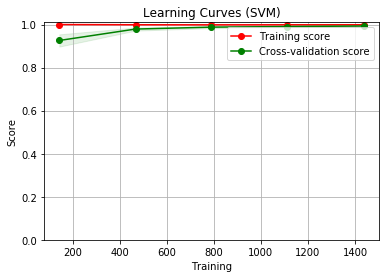

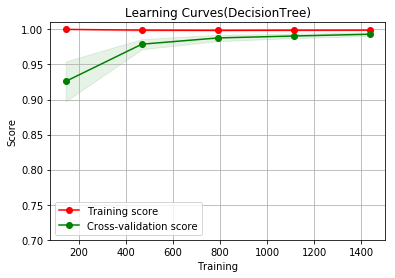

In [372]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


digits = load_digits()
X, y = digits.data, digits.target


title = "Learning Curves (SVM)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves(DecisionTree)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
eestimator = DecisionTreeClassifier(max_depth=4,random_state=123)
plot_learning_curve(estimator, title, X, y, (.7, 1.01), cv=cv, n_jobs=4)

plt.show()

#### with standardization

In [ ]:
!pip install sklearn_pandas
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [ ]:
X_train.dtypes

In [ ]:
df= df.drop(["id"],axis=1)

In [ ]:
df.columns

In [ ]:
mapper=[]

mapper = DataFrameMapper(
  [([continuous_col], StandardScaler()) for continuous_col in continuous_cols])

In [ ]:
print(type(mapper))

In [ ]:
mapper.fit(X_train)

X_train_std = mapper.transform(X_train)
X_test_std = mapper.transform(X_test)

In [ ]:
X_train_std[0:1,]

In [ ]:
X_test_std

In [ ]:
estimator1 = DecisionTreeClassifier(max_depth=4,random_state=123)
estimator1.fit(X_train_std, y_train)

y1_pred_ = estimator1.predict(X_train_std)
y_pred_ = estimator1.predict(X_test_std)

print(accuracy_score(y_train,y1_pred_))
print(classification_report(y_train,y1_pred_,digits=4))
print("\n")

print(accuracy_score(y_test,y_pred_))
print(classification_report(y_test,y_pred_,digits=4))

#### build Random forest Classifier


In [266]:
from sklearn.ensemble import RandomForestClassifier

In [267]:
clf = RandomForestClassifier(n_estimators=10,max_depth =8)
clf.fit(X=X_train, y=y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [268]:
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))

y_pred = clf.predict(X_train)
print(accuracy_score(y_train,y_pred))



0.6253968253968254
0.6645321609481029


In [269]:
y_pred = clf.predict(X_train)
print(accuracy_score(y_train,y_pred))
print(classification_report(y_test,y_pred_,digits=4))

0.6645321609481029
              precision    recall  f1-score   support

           0     0.9009    0.6155    0.7313      8965
           1     0.1927    0.5755    0.2888      1430

    accuracy                         0.6100     10395
   macro avg     0.5468    0.5955    0.5101     10395
weighted avg     0.8035    0.6100    0.6705     10395



In [270]:
len(clf.feature_importances_)

171

In [271]:
clf.feature_importances_

array([5.97839993e-02, 1.32105176e-02, 7.09695127e-02, 5.83508326e-02,
       1.11235084e-01, 1.77136898e-02, 6.13030138e-03, 2.70025009e-03,
       8.55049078e-03, 4.26330027e-03, 0.00000000e+00, 4.74233951e-03,
       9.77162381e-03, 5.24959590e-04, 2.58645425e-03, 2.35238293e-03,
       5.29967941e-03, 2.89414977e-02, 2.62590285e-03, 1.77323643e-02,
       2.80429529e-03, 7.34408204e-03, 1.42502862e-03, 2.98086077e-03,
       3.31587309e-03, 3.99260939e-03, 3.27644253e-03, 4.65358517e-03,
       3.47776171e-03, 0.00000000e+00, 5.33490427e-03, 2.58850552e-03,
       2.57062678e-05, 0.00000000e+00, 4.05225811e-03, 9.89306313e-04,
       5.84670878e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.20396843e-03, 2.38627363e-03, 8.29647148e-04, 5.93176646e-04,
       2.70573878e-03, 5.85222215e-03, 2.51083659e-03, 1.19108123e-03,
       2.79701963e-03, 2.50850111e-03, 1.29894300e-03, 0.00000000e+00,
      

#### Grid search Validation

In [272]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt') 
 
# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [54],
           "max_depth" : [7],
           "min_samples_leaf" : [4]}
scores = ['precision', 'recall']

In [273]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(estimator=rfc, param_grid=param_grid,cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'max_depth': 7, 'min_samples_leaf': 4, 'n_estimators': 54}

Grid scores on development set:

0.636 (+/-0.016) for {'max_depth': 7, 'min_samples_leaf': 4, 'n_estimators': 54}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.90      0.63      0.74      8965
           1       0.19      0.55      0.28      1430

    accuracy                           0.62     10395
   macro avg       0.54      0.59      0.51     10395
weighted avg       0.80      0.62      0.68     10395


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'max_depth': 7, 'min_samples_leaf': 4, 'n_estimators': 54}

Grid scores on development set:

0.636 (+/-0.010) for {'max_depth': 7, 'min_samples_leaf': 4, 'n_estimators': 54}

Detailed cl

In [274]:
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))

y_pred = clf.predict(X_train)
print(accuracy_score(y_train,y_pred))

print(recall_score(y_train,y_pred,pos_label=1))

0.6241462241462241
0.6506499092038612
0.6574118321705056


In [275]:
param_grid

{'n_estimators': [54], 'max_depth': [7], 'min_samples_leaf': [4]}

In [276]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid,cv=5,verbose=1)
CV_rfc.fit(X=X_train, y=y_train)

print (CV_rfc.best_score_, CV_rfc.best_params_) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.3s finished


0.6368871260632706 {'max_depth': 7, 'min_samples_leaf': 4, 'n_estimators': 54}


In [277]:
CV_rfc.cv_results_

{'mean_fit_time': array([2.150104]),
 'std_fit_time': array([0.17943338]),
 'mean_score_time': array([0.11660628]),
 'std_score_time': array([0.00172168]),
 'param_max_depth': masked_array(data=[7],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[4],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[54],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 7, 'min_samples_leaf': 4, 'n_estimators': 54}],
 'split0_test_score': array([0.63449594]),
 'split1_test_score': array([0.64444444]),
 'split2_test_score': array([0.62879331]),
 'split3_test_score': array([0.64157706]),
 'split4_test_score': array([0.63512545]),
 'mean_test_score': array([0.63688713]),
 'std_test_score': array([0.00553956]),
 'rank_test_score': array([1])}

In [278]:
y_pred_test=CV_rfc.predict(X_test)
print(accuracy_score(y_test,y_pred_test))

0.6172198172198172


In [279]:
from sklearn.metrics import recall_score
print(recall_score(y_test,y_pred_test, pos_label=1, average='binary'))

0.5608391608391609


#### AdaBoost

In [280]:
# Create adaboost-decision tree classifer object
Adaboost_model = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators = 600,
    learning_rate = 1)

In [281]:
%time Adaboost_model.fit(X_train, y_train)

Wall time: 4min 52s


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [282]:
y_preds = Adaboost_model.predict(X_test)

In [283]:
print(accuracy_score(y_test, y_preds))
print(recall_score(y_test,y_pred_test, pos_label=1))

0.663973063973064
0.5608391608391609


In [284]:
param_grid = {'n_estimators' : [200],
              'learning_rate' : [0.9]}

Adaboost_model_clf = GridSearchCV(AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=2)), param_grid, n_jobs=-1)

In [285]:
%time Adaboost_model_clf.fit(X_train, y_train)

Wall time: 3min 19s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=2,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
                                                                              

In [286]:
best_ada_model = Adaboost_model_clf.best_estimator_
print (Adaboost_model_clf.best_score_, Adaboost_model_clf.best_params_) 

0.667160470228424 {'learning_rate': 0.9, 'n_estimators': 200}


In [287]:
y_pred_test = best_ada_model.predict(X_test)

In [288]:
print(accuracy_score(y_test,y_pred_test))
print(recall_score(y_test,y_pred_test, pos_label=1))

0.6291486291486291
0.5188811188811189


In [289]:
print(confusion_matrix(y_test, y_pred_test))

[[5798 3167]
 [ 688  742]]


#### building Gradient boosting classifier

Gradient boosting is a type of boosting. 

The key idea behind gradient boosting is to set the target outcomes for this next model in order to minimize the error. The target outcome for each case in the data set depends on how much a change in that case’s prediction impacts the overall prediction error.

If, for case X(i), a small change in the prediction causes a large drop in error, then the next target outcome is a high value. Predictions from the new model that are close to its targets will reduce the error.

If, for case X(j), a small change in the prediction causes no change in error, then the next target outcome is zero because changing this prediction does not decrease the error.

The name gradient boosting arises because of setting target outcomes based on the gradient of the error with respect to the prediction of each case. Each new model takes a step in the direction that minimizes prediction error, in the space of possible predictions for each training case.

1. Initialize the outcome
2. Iterate from 1 to total number of trees
  <br>2.1 Update the weights for targets based on previous run (higher for the ones mis-classified)
  <br>2.2 Fit the model on selected subsample of data
  <br>2.3 Make predictions on the full set of observations
  <br>2.4 Update the output with current results taking into account the learning rate
3. Return the final output.

The most important parameters are learning_rate, n_estimators and subsample
- **learning_rate**
    -  This determines the impact of each tree on the final outcome (step 2.4). GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates.
    -  Lower values are generally preferred as they make the model robust to the specific characteristics of tree and thus allowing it to generalize well.
    -  Lower values would require higher number of trees to model all the relations and will be computationally expensive.
- **n_estimators**
    -  The number of sequential trees to be modeled (step 2)
    -  Though GBM is fairly robust at higher number of trees but it can still overfit at a point. Hence, this should be tuned using CV for a particular learning rate.
- **subsample**
    -  The fraction of observations to be selected for each tree. Selection is done by random sampling.
    -  Values slightly less than 1 make the model robust by reducing the variance.
    -  Typical values ~0.8 generally work fine but can be fine-tuned further.

In [290]:
GBM_model = GradientBoostingClassifier(n_estimators=50,
                                       learning_rate=0.3,
                                       subsample=0.8)

In [291]:
%time GBM_model.fit(X=X_train, y=y_train)

Wall time: 26.6 s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.3, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [292]:
y_pred = GBM_model.predict(X_test)

In [293]:
print(accuracy_score(y_test,y_pred))
print(recall_score(y_test,y_pred_test, pos_label=1))
print(classification_report(y_test,y_pred,digits=4))

print(confusion_matrix(y_test, y_pred_test))

0.6111592111592111
0.5188811188811189
              precision    recall  f1-score   support

           0     0.9017    0.6163    0.7322      8965
           1     0.1940    0.5790    0.2906      1430

    accuracy                         0.6112     10395
   macro avg     0.5479    0.5977    0.5114     10395
weighted avg     0.8044    0.6112    0.6714     10395

[[5798 3167]
 [ 688  742]]


In [103]:
#X_id=testtoput['patientID']

In [158]:
#y_pred_test=clf.predict(testtoput)
#y_pred_test=best_ada_model.predict(testtoput)
#y_pred_test=Adaboost_model.predict(testtoput)
#y_pred_test=clf.predict(testtoput)
#y_pred_test=CV_rfc.predict(testtoput)
#y_pred_test=BernoulliNB_model.predict(testtoput)
y_pred_test=log_reg.predict(testtoput)

In [ ]:
#y_pred_test = estimator.predict(X_test)
#print(accuracy_score(y_test,y_pred_test))
#print(confusion_matrix(y_test, y_pred_test))

In [159]:
final_log_regg=pd.DataFrame(X_id)

In [160]:
final_log_regg['readmitted']=y_pred_test

In [161]:
final_log_regg.head()

,patientID,readmitted
0,PT60251,1
1,PT60252,0
2,PT60253,1
3,PT60254,0
4,PT60255,1


In [162]:
export_csv = final_log_regg.to_csv (r'C:/Users/sa/Desktop/sa/Adarsh Data/2019/Common files/Big Data/BD/PHD/PHD Part 2/TrainData-1564147787554/final_log_regg.csv', index = None, header=True)